In [1]:
%config Completer.use_jedi = False

# KNN Grid Search - CS Project

In [3]:
# Import modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

# Data
The data to be processed is taken from the UCI Machine Learning Repository, and contains information from the 1994 Census Database. The prediction task is to determine whether a person makes over $50k a year.

In [4]:
# List of column names
names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "earns-over-50k"  
]

In [5]:
# Read data from CSV
df_raw = pd.read_csv(
    "./adult_ws.data", 
    names=names, 
    delimiter=", *", 
    na_values="?", 
    engine="python"
)

In [6]:
# All columns containing categorical data
categoricals = df_raw.select_dtypes(exclude=np.number).columns

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

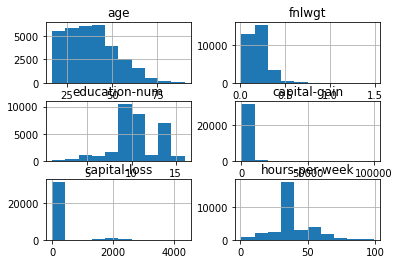

In [7]:
df_raw.hist()

In [8]:
df_raw.describe(include=[np.number])

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [9]:
df_raw.describe(include=[object])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,earns-over-50k
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


# Preprocessing
Preprocessing handles five things:
1. Missing values
1. Imbalanced class distribution
1. Features and Classes (X, y) split
1. Categorical data
1. Normalising data

## Missing values 
I could handle missing values in two ways:
- Delete records with missing values
- Use averages of a feature to fill missing values

I am currently using the second method, although I will have to evaluate the performance of both in the future.

In [10]:
# Print modal averages for future reference
df_raw.mode().loc[0]

age                             36.0
workclass                    Private
fnlwgt                        123011
education                    HS-grad
education-num                    9.0
marital-status    Married-civ-spouse
occupation            Prof-specialty
relationship                 Husband
race                           White
sex                             Male
capital-gain                     0.0
capital-loss                     0.0
hours-per-week                  40.0
native-country         United-States
earns-over-50k                 <=50K
Name: 0, dtype: object

In [11]:
# Print number of rows with missing values 
print(f"Number of rows with missing values: {df_raw.isna().any(axis=1).sum()}\n")

# Print missing values per column
# The number of total missing values will be greater than the no of rows because some rows will have multiple missing features
print(df_raw.isna().sum())

Number of rows with missing values: 2399

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
earns-over-50k       0
dtype: int64


As there only categorical features have missing values, I only need to apply the replacement to categorical features.

In [12]:
# # Remove rows with missing values
# df_no_missing = df_raw[~(df_raw == "?").any(axis=1)]
# df_only_missing = df_raw[(df_raw == "?").any(axis=1)]

# # Replace missing categorical values with most common
df_no_missing = df_raw.copy()
df_no_missing[categoricals] = df_raw[categoricals].fillna(df_raw.mode().loc[0])

In [13]:
# Print number of rows with missing values 
print(f"Number of rows with missing values: {df_no_missing.isna().any(axis=1).sum()}")

Number of rows with missing values: 0


In [14]:
# # Print size of dataset before and after removing values
# print(f"Original dataset size: {len(df_raw.index)} records")
# print(f"Reduced dataset size:  {len(df_no_missing.index)} records")
# print(f"No. of removed values: {len(df_only_missing.index)} records")

In [15]:
# df_no_missing.corrwith(df_no_missing["earns-over-50k"].replace({">50K": True, "<=50K": False}))

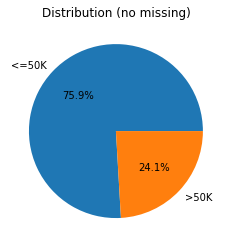

In [16]:
# Draw pie charts to show distribution of classes across dataset
def distribution_pie(ax, distribution, label):
    ax.pie(distribution, labels=distribution.index, autopct="%1.1f%%")
    ax.set_title(f"Distribution ({label})")

# If no rows are removed, only one pie chart is necessary.
_, ax = plt.subplots(1,1)

distribution = df_no_missing["earns-over-50k"].value_counts()
distribution_pie(ax, distribution, "no missing")
plt.savefig("dist_before.png")

# # If there are rows removed, I will show three pie charts: "raw", "without missing" and "only missing".
# _, ax = plt.subplots(1,3)

# distribution_raw = df_raw["earns-over-50k"].value_counts()
# distribution_pie(ax[0], distribution_raw, "raw")

# distribution_nm = df_no_missing["earns-over-50k"].value_counts()
# distribution_pie(ax[1], distribution_nm, "no missing")

# distribution_jm = df_only_missing["earns-over-50k"].value_counts()
# distribution_pie(ax[2], distribution_jm, "only missing")

Because the significant majority of records in the dataset make <=50K, some form of data augmentation is needed, with synthetic generation of samples.

## Class distribution
The following cells use oversampling to generate new instances of minority classes by duplicating existing records and applying noise on their numerical features.

In [16]:
dominant_class_size = df_no_missing['earns-over-50k'].value_counts().max()
# dominant_class_size is 24720

# Function to add noise to numerical data
def add_noise(x):
    if type(x) == str:
        return x
    return x * (1 + np.random.randn()/10)

# Peform oversampling
df_to_lst = [df_no_missing]
for class_index, group in df_no_missing.groupby('earns-over-50k'):
    new_records = group.sample(
        dominant_class_size-len(group), 
        replace=True
    ).applymap(add_noise)
    df_to_lst.append(new_records)
    
df_equal_dist = pd.concat(df_to_lst)

In [17]:
# Check number of duplicate records before and after (should ideally be the same)
before = df_no_missing.groupby(df_no_missing.columns.tolist(),as_index=False).size()
print("Before resampling:", len(before[before["size"]>1]))

after = df_equal_dist.groupby(df_equal_dist.columns.tolist(),as_index=False).size()
print("After resampling:", len(after[after["size"]>1]))

Before resampling: 23
After resampling: 23


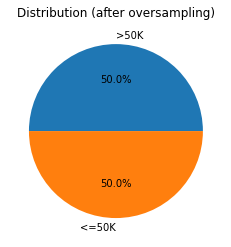

In [18]:
# Check distribution of classes after oversampling
_, ax = plt.subplots(1,1)
distribution = df_equal_dist["earns-over-50k"].value_counts()
distribution_pie(ax, distribution, "after oversampling")

## Distribution across categorical data
The following cell outputs the distribution of categories within categorical features. I will come back to this in the future, to determine whether binning may be necessary.

In [19]:
# Print distribution of records across categorical data
# for c in df_equal_dist[categoricals]:
#     print(f"\n------ {c} ------")
#     print(df_equal_dist[c].value_counts())

## Save Preprocessed CSV
Having preprocessed the data, it must be saved to be read by the training script.

In [21]:
df_equal_dist.to_csv("preprocessed.csv", header=False)